In [1]:
from astropy.io import fits
import numpy as np
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
import matplotlib
%matplotlib inline
import datetime as dt
from astropy.stats import LombScargle

In [19]:
params = {
    'xtick.labelsize':10,
    'ytick.labelsize':10,
    'axes.labelsize':10,
    'legend.fontsize':8,
    'font.family':'Times New Roman',
    'font.weight':'normal',
    'text.usetex':True
}
matplotlib.rcParams.update(params)

width = 3.4
height = width * .8

In [20]:
data_927 = pd.read_excel('../data/0927_measurements.xlsx')
filebase_927 = '../data/science/0927/processed/'
obs_927 = [fits.getheader(filebase_927 + row['Label'])['DATE-OBS'] for index, row in data_927.iterrows()]
data_927['DATE-OBS'] = obs_927

data_1018 = pd.read_excel('../data/1018_measurements.xlsx')
filebase_1018 = '../data/science/1018/processed/'
obs_1018 = [fits.getheader(filebase_1018 + row['Label'])['DATE-OBS'] for index, row in data_1018.iterrows()]
data_1018['DATE-OBS'] = obs_1018

In [21]:
full_data = data_927.append(data_1018, ignore_index=True)
fmt = '%Y-%m-%dT%H:%M:%S.%f'
times = [dt.datetime.strptime(time, fmt) for time in full_data['DATE-OBS']]
time_since = [(time - times[0]).total_seconds() / (60) for i, time in enumerate(times)]
full_data['Time Since'] = time_since

# full_data.to_csv('../data/full_data.csv')
t, mags, err = full_data[['Time Since', 'Source_AMag_T1', 'Source_AMag_Err_T1']].values.T

C:\Users\drumm\Anaconda3\lib\site-packages\matplotlib\figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


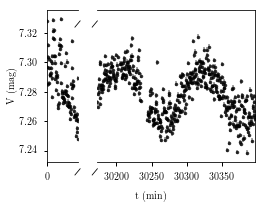

In [22]:
from brokenaxes import brokenaxes

d1_max = max(full_data['Time Since'][full_data['Time Since'] < 100])
d2_min = min(full_data['Time Since'][full_data['Time Since'] > 100])

bax = brokenaxes(xlims=((min(t), d1_max),(d2_min, max(t))), wspace=0.2,despine=False)
bax.errorbar(t, mags, yerr=err, alpha=0.8, fmt='.', c='k', ecolor='gray')
bax.set_xlabel('t (min)')
bax.set_ylabel('V (mag)')

plt.tight_layout()
bax.fig.set_size_inches(width, height)
bax.fig.savefig('../docs/project/figs/rawmags.pdf')

In [23]:
# frequency = np.linspace(1./100, 1./130, 100)
LS = LombScargle(t, mags, dy=err, nterms=1)
frequency, power = LS.autopower()
best_frequency = frequency[np.argmax(power)]
phase = (t * best_frequency) % 2

phase_fit = np.linspace(0, 2)
y_fit = LS.model(phase_fit / best_frequency, best_frequency)

print('Best Frequency: ', best_frequency)
print('Best Period: {} min   {} d'.format(1/best_frequency, 1/best_frequency/60/24))

Best Frequency:  0.00880673702772
Best Period: 113.54943344539907 min   0.07885377322597158 d


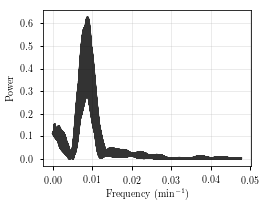

In [24]:
plt.plot(frequency, power, 'k', alpha=.8)
plt.grid(True, alpha=.25)
plt.xlabel(r'Frequency (min^{-1})')
plt.ylabel('Power')
plt.tight_layout()
plt.gcf().set_size_inches(width, height)
plt.savefig('../docs/project/figs/power.pdf')

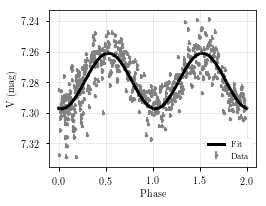

In [25]:
plt.figure()
plt.gca().invert_yaxis()
plt.plot(phase_fit, y_fit, c='k', lw=3, label='Fit', zorder=1)
plt.errorbar(phase, mags, yerr=err, fmt='.', label='Data', c='gray', zorder=0)
plt.grid(True, alpha=.25)
plt.legend()
plt.xlabel('Phase')
plt.ylabel('V (mag)')
plt.tight_layout()
plt.gcf().set_size_inches(width, height)
plt.savefig('../docs/project/figs/fit.pdf')